# Set up

In [48]:
import dask
import xgboost
import dask_xgboost
import numpy as np
import dask.dataframe as dd 
from dask.distributed import Client
import pandas as pd

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:54419 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 19.84 GiB


# Data Splitting and Downsampling

In [3]:
from dask_ml.model_selection import train_test_split

In [4]:
df = dd.read_csv('pooled_clean.csv')

In [5]:
df['violence'].value_counts().compute() * 0.8

0    40958.4
1    17566.4
Name: violence, dtype: float64

In [6]:
random_state = 5
np.random.seed(random_state)

In [7]:
yes_indices = df[df.violence == 1].index
no_indices = df[df.violence != 1].index
train_yes_indices = np.random.choice(yes_indices, 17567, replace=False)
train_no_indices = np.random.choice(no_indices, 20000, replace=False)
train_indices = np.concatenate((train_yes_indices, train_no_indices), axis=0)
train = df.loc[lambda df: df.index.isin(train_indices)]
test = df.loc[lambda df: ~df.index.isin(train_indices)]

In [8]:
train['violence'].value_counts().compute()

0    20000
1    17567
Name: violence, dtype: int64

In [9]:
y_train = train['violence']
y_test = test['violence']

In [10]:
X_train = train.drop('violence', axis=1)
X_test = test.drop('violence', axis=1)

In [11]:
from dask_ml.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.drop('country', axis=1))
X_test = scaler.fit_transform(X_test.drop('country', axis=1))

In [12]:
X_train.head()

,age,age_first,duration,urban,edu,n_children,employ_paid,own_house,own_land,att_wb,fam_ipv,part_age,part_edu,alcohol,wealth_idx,telephone_yes
0,0.588235,0.354167,0.386364,0.0,0.50,0.1,0.0,0.0,0.0,0.0,0.0,0.3625,0.40,0.0,0.00,0.0
1,0.647059,0.395833,0.409091,0.0,0.00,0.1,0.0,0.0,0.0,1.0,0.0,0.3750,0.25,0.0,0.25,0.0
2,0.500000,0.416667,0.250000,0.0,0.00,0.0,0.0,0.0,0.0,1.0,0.0,0.3500,0.50,0.0,0.00,0.0
4,1.000000,0.500000,0.568182,0.0,0.25,0.0,0.0,0.0,0.0,0.0,1.0,0.4375,0.00,0.0,0.00,0.0
5,0.294118,0.416667,0.113636,0.0,0.70,0.2,0.0,0.0,0.0,1.0,0.0,0.2000,0.50,0.0,0.25,0.0


# Logistic Regression

In [13]:
from dask_ml.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, recall_score, plot_roc_curve, plot_confusion_matrix
from dask_ml.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [14]:
parameters = {'penalty': ['l1', 'l2'], 'C': np.arange(0.1, 1, 0.1)}
lr = LogisticRegression()

In [15]:
X_train_array = X_train.to_dask_array(lengths=True)
y_train_array = y_train.to_dask_array(lengths=True)
X_test_array = X_test.to_dask_array(lengths=True)
y_test_array = y_test.to_dask_array(lengths=True)

In [16]:
cvlr = GridSearchCV(lr, parameters, cv=5)

In [17]:
cvlr.fit(X_train_array, y_train_array)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'penalty': ['l1', 'l2']})

In [18]:
cvlr.best_params_

{'C': 0.9, 'penalty': 'l2'}

In [19]:
best_lr = LogisticRegression(penalty=cvlr.best_params_['penalty'], C=cvlr.best_params_['C'])
best_lr.fit(X_train_array, y_train_array)

LogisticRegression(C=0.9)

In [20]:
best_lr._estimator_type = 'classifier'
best_lr.classes_ = np.array([0, 1])

In [21]:
yhat = best_lr.predict(X_test_array).compute()

In [22]:
best_lr.score(X_test_array, y_test_array).compute()

0.7550085700637837

In [23]:
recall_score(y_test, yhat)#, average='weighted')

0.5843771350489638

In [24]:
roc_auc_score(y_test, best_lr.predict_proba(X_test_array)[:, 1].compute())

0.7452594129612774

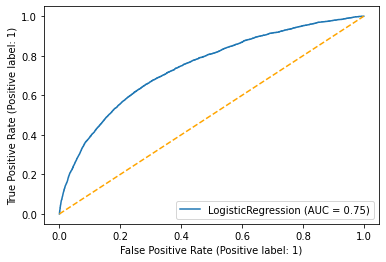

In [163]:
best_lr_disp = plot_roc_curve(best_lr, X_test_array, y_test_array)
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.savefig("ROC_lr.png")
plt.show()

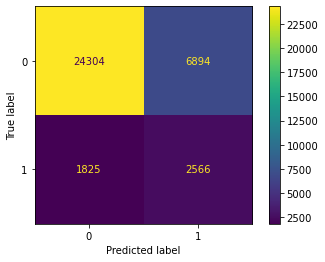

In [162]:
plt.close()
confu_lr = plot_confusion_matrix(best_lr, X_test_array, y_test_array)
plt.savefig("conf_mat_lr.png")
plt.show()

In [165]:
lr_coef = pd.DataFrame({'coef': best_lr.coef_})
lr_coef.index=X_train.columns
lr_coef.sort_values(by='coef', inplace=True, ascending=False)
lr_coef

,coef
urban,2.648361
part_age,1.296744
employ_paid,1.239882
duration,1.176684
wealth_idx,1.005908
fam_ipv,0.624097
own_house,0.251076
edu,0.124068
own_land,0.059513
att_wb,-0.089306


# Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
rf_parameters = {'max_features': [4, 8, 12],
                 'max_depth': [4, 8], 
                 'n_estimators': [500, 750, 1000]
                }
rf = RandomForestClassifier(random_state=random_state)

In [31]:
cv_rf = GridSearchCV(rf, rf_parameters, cv=5)

In [32]:
cv_rf.fit(X_train_array, y_train_array)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=5),
             param_grid={'max_depth': [4, 8], 'max_features': [4, 8, 12],
                         'n_estimators': [500, 750, 1000]})

In [33]:
cv_rf.best_params_

{'max_depth': 4, 'max_features': 4, 'n_estimators': 500}

In [41]:
cv_rf.best_estimator_.score(X_test_array, y_test_array)

0.763747225266234

In [42]:
yhat_rf = cv_rf.best_estimator_.predict(X_test_array)

In [43]:
recall_score(y_test, yhat_rf)#, average='weighted')

0.5780004554771123

In [40]:
roc_auc_score(y_test, cv_rf.best_estimator_.predict_proba(X_test_array)[:, 1])

0.748193913825418

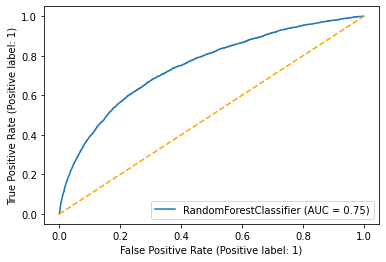

In [161]:
plt.close()
best_rf_disp = plot_roc_curve(cv_rf.best_estimator_, X_test_array, y_test_array)
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.savefig("ROC_rf.png")
plt.show()

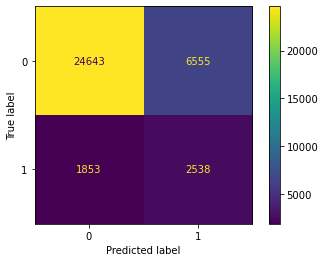

In [159]:
plt.close()
conf_mat_rf = plot_confusion_matrix(cv_rf.best_estimator_, X_test_array, y_test_array)
plt.savefig("conf_mat_rf.png")
plt.show()

# Pooled Feature Importance

In [107]:
forest_importances = forest_importances = pd.DataFrame({'imp': cv_rf.best_estimator_.feature_importances_})
forest_importances.index=X_train.columns
forest_importances.sort_values(by='imp', inplace=True, ascending=False)
forest_importances['95% imp'] = forest_importances['imp'].cumsum()

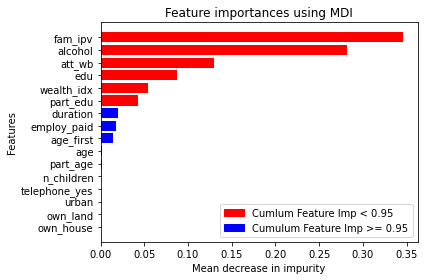

In [133]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots()
std = np.std([cv_rf.best_estimator_.feature_importances_ \
             for tree in cv_rf.best_estimator_.feature_importances_], axis=0)
ax.barh(forest_importances.index, forest_importances['imp'], xerr=std, align='center', 
        color=['red' if imp < 0.95 else 'blue' for imp in forest_importances['95% imp'] ])
ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity")
ax.set_ylabel("Features")
plt.gca().invert_yaxis()
red_patch = mpatches.Patch(color='red', label='Cumlum Feature Imp < 0.95')
blue_patch = mpatches.Patch(color='Blue', label='Cumulum Feature Imp >= 0.95')
plt.legend(handles=[red_patch, blue_patch], loc='lower right')
fig.tight_layout()
plt.savefig("pool_fi.png")

# Country-Specific Permutation Feature Importance

In [134]:
from sklearn.inspection import permutation_importance

In [149]:
def extract_country(df, country):
    '''
    extract obs from the same country from a dataset
    '''
    X_test = test.drop('violence', axis=1).loc[test['country'] == country, :]
    X_test = X_test.drop('country', axis=1)
    y_test = test.loc[test['country'] == country, 'violence']
    
    return X_test, y_test

In [150]:
X_test_PK, y_test_PK = extract_country(test, "PK")
X_test_IA, y_test_IA = extract_country(test, "IA")
X_test_NP, y_test_NP = extract_country(test, "NP")

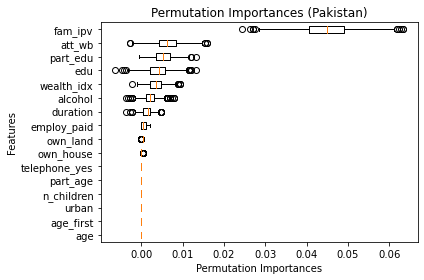

In [152]:
plt.close()
result = permutation_importance(cv_rf.best_estimator_, X_test_PK.compute(), y_test_PK.compute(), 
                                n_repeats=1000,
                                random_state=random_state, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (Pakistan)")
ax.set_ylabel("Features")
ax.set_xlabel("Permutation Importances")
fig.tight_layout()
plt.savefig("fi_PK.png")
plt.show()

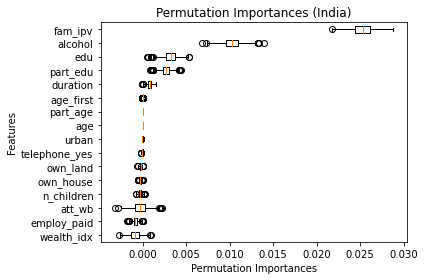

In [153]:
plt.close()
result = permutation_importance(cv_rf.best_estimator_, X_test_IA.compute(), y_test_IA.compute(), 
                                n_repeats=1000,
                                random_state=random_state, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (India)")
ax.set_ylabel("Features")
ax.set_xlabel("Permutation Importances")
fig.tight_layout()
plt.savefig("fi_IA.png")
plt.show()

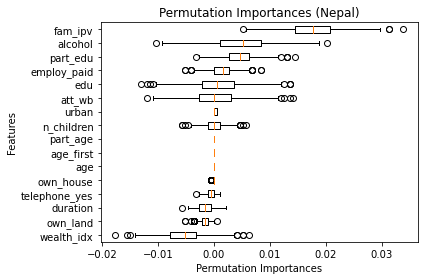

In [154]:
plt.close()
result = permutation_importance(cv_rf.best_estimator_, X_test_NP.compute(), y_test_NP.compute(), 
                                n_repeats=1000,
                                random_state=random_state, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (Nepal)")
ax.set_ylabel("Features")
ax.set_xlabel("Permutation Importances")
fig.tight_layout()
plt.savefig("fi_NP.png")
plt.show()